In [1]:
## 기본 library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
## model library
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from keras import models, layers, optimizers
## helper library
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.backend as K
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from bayes_opt import BayesianOptimization

data = pd.read_csv('../1.clustering/titanic.csv')

target = data['Survived']
data = data.drop(['PassengerId', 'Survived'], axis=1)

Using TensorFlow backend.


In [2]:
d = data.copy()
categorical = [
    'Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked'
]

In [3]:
data['Age'] = pd.DataFrame(MinMaxScaler().fit_transform(data['Age'].values.reshape(-1,1)))
data['Fare'] = pd.DataFrame(StandardScaler().fit_transform(data['Fare'].values.reshape(-1,1)))

lbe = LabelEncoder()
data['Sex'] = lbe.fit_transform(data['Sex'])
sex = lbe.classes_
data['Embarked'] = lbe.fit_transform(data['Embarked'])
emb = lbe.classes_

for c in categorical:
    data = pd.concat([data, pd.get_dummies(data[c], prefix=c)], axis=1)
    data = data.drop(c, axis=1)

In [4]:
train_X, test_X, train_y, test_y = train_test_split(data, target, test_size=0.3, random_state=0, shuffle=True)

In [5]:
kfold = KFold(n_splits=10, shuffle=True, random_state=0)

In [6]:
## logistic
acc = 0
for tr_idx, val_idx in kfold.split(train_X):
    tr_X, tr_y = train_X.iloc[tr_idx, :], train_y.iloc[tr_idx]
    val_X, val_y = train_X.iloc[val_idx, :], train_y.iloc[val_idx]
    lr = LogisticRegression(random_state=0).fit(tr_X, tr_y)
    acc += accuracy_score(val_y, lr.predict(val_X))/10

print(acc)

0.799265306122449


In [7]:
## 조금 더 간단히 할 수 있음
lr  = LogisticRegression(random_state=0)
acc = cross_val_score(lr, train_X, train_y, cv=kfold, n_jobs=1, scoring='accuracy')
print(np.mean(acc))

0.7992653061224491


In [8]:
lr = LogisticRegression(random_state=0).fit(train_X, train_y)

In [9]:
## knn
opt = []
for n in range(2, 30):
    knn = KNeighborsClassifier(n_neighbors=n)
    acc = []
    for tr_idx, val_idx in kfold.split(train_X):
        tr_X, tr_y = train_X.iloc[tr_idx, :], train_y.iloc[tr_idx]
        val_X, val_y = train_X.iloc[val_idx, :], train_y.iloc[val_idx]
        knn.fit(tr_X, tr_y)
        acc.append(accuracy_score(val_y, knn.predict(val_X)))
    opt.append(np.mean(acc))

[0.7811020408163265, 0.8093061224489796, 0.7791836734693878, 0.7951428571428572, 0.7952653061224491, 0.7953469387755102, 0.7973469387755102, 0.7953061224489797, 0.8033061224489797, 0.7952244897959184, 0.7972244897959184, 0.793265306122449, 0.7892653061224489, 0.7933469387755101, 0.8053469387755102, 0.8053877551020407, 0.7933061224489796, 0.7973469387755102, 0.7893469387755102, 0.8013061224489796, 0.7853469387755101, 0.7953877551020407, 0.7913877551020408, 0.7953061224489797, 0.7893469387755102, 0.7892653061224489, 0.7892244897959183, 0.791265306122449]


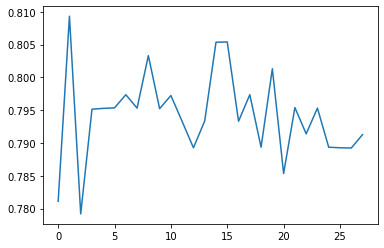

In [10]:
plt.plot(opt)
print(opt)


In [11]:
## knn's n_neighbor = 3
knn = KNeighborsClassifier(n_neighbors=3).fit(train_X, train_y)

In [12]:
## RF with no paramter tuning
acc = 0
for tr_idx, val_idx in kfold.split(train_X):
    tr_X, tr_y = train_X.iloc[tr_idx, :], train_y.iloc[tr_idx]
    val_X, val_y = train_X.iloc[val_idx, :], train_y.iloc[val_idx]
    rf = RandomForestClassifier(random_state=0).fit(tr_X, tr_y)
    acc += accuracy_score(val_y, rf.predict(val_X))/10

print(acc)

0.7832653061224489


In [13]:
rf = RandomForestClassifier(random_state=0).fit(train_X, train_y)

In [14]:
## xgboost
xgb_bounds = {
    'max_depth': (3, 12),
    'subsample': (0.3, 1),
    'colsample_bytree': (0.3, 1),
    'reg_alpha': (0.1, 3),
    'reg_lamda': (0.1, 3)
}

best_ns = []

def bayes_xgb(max_depth, subsample, colsample_bytree, reg_alpha, reg_lamda):
    global best_ns
    params = {
        'n_estimators': 1000,
        'booster': 'gbtree',
        'tree_method': 'hist',
        'random_state': 0,
        'n_jobs': -1,
        'max_depth': int(max_depth),
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'reg_alpha': reg_alpha,
        'reg_lamda': reg_lamda
    }
    
    acc = 0
    best_n = 0
    for tr_idx, val_idx in kfold.split(train_X):
        tr_X, tr_y = train_X.iloc[tr_idx, :], train_y.iloc[tr_idx]
        val_X, val_y = train_X.iloc[val_idx, :], train_y.iloc[val_idx]
        clf = XGBClassifier(**params).fit(tr_X, tr_y, eval_metric = 'error', eval_set=[[val_X, val_y]], early_stopping_rounds=100, verbose=0)
        acc += accuracy_score(val_y, clf.predict(val_X))/10
        best_n += clf.best_iteration/10
    best_ns.append(best_n)
    return acc


In [16]:
%%time
optimizer = BayesianOptimization(bayes_xgb, xgb_bounds, random_state=0)

init_points = 10
n_iter = 20

optimizer.maximize(init_points=init_points, n_iter=n_iter)

|   iter    |  target   | colsam... | max_depth | reg_alpha | reg_lamda | subsample |
-------------------------------------------------------------------------------------


KeyboardInterrupt: 

In [17]:
import pickle
with open('best_params.bin', 'rb') as f:
    best_params = pickle.load(f)

In [18]:
optimizer.max['params']

KeyError: 'params'

In [19]:
best_params = {
    'n_estimators': int(best_ns[12]),
    'booster': 'gbtree',
    'tree_method': 'hist',
    'random_state': 0,
    'n_jobs': -1,
    'max_depth': int(optimizer.max['params']['max_depth']),
    'subsample': optimizer.max['params']['subsample'],
    'colsample_bytree': optimizer.max['params']['colsample_bytree'],
    'reg_alpha': optimizer.max['params']['reg_alpha'],
    'reg_lamda': optimizer.max['params']['reg_lamda'],
    'metric': 'error'
}

clf = XGBClassifier(**best_params).fit(train_X, train_y)


In [20]:
## voting
from sklearn.ensemble import VotingClassifier

v_lr = LogisticRegression(random_state=0)
v_knn = KNeighborsClassifier(n_neighbors=3)
v_rf = RandomForestClassifier(max_depth=9, random_state=0)

vclf = VotingClassifier(estimators=[
    ('lr', v_lr),
    ('knn', v_knn),
    ('rf', v_rf)
], voting='soft')

acc = 0
for tr_idx, val_idx in kfold.split(train_X):
    tr_X, tr_y = train_X.iloc[tr_idx, :], train_y.iloc[tr_idx]
    val_X, val_y = train_X.iloc[val_idx, :], train_y.iloc[val_idx]
    vclf.fit(tr_X, tr_y)
    acc += accuracy_score(val_y, vclf.predict(val_X))/10

print(acc)

0.8073061224489797


개별 모델들과 앙상블모형을 통틀어 xgboost가 가장 높은 성능을 보여줄 것으로 기대된다.  
실제 test셋의 결과는 어떨까?


In [21]:
print('lr:', accuracy_score(test_y, lr.predict(test_X)))
print('knn:', accuracy_score(test_y, knn.predict(test_X)))
print('rf:', accuracy_score(test_y, rf.predict(test_X)))
print('xgboost:', accuracy_score(test_y, clf.predict(test_X)))
print('voting:', accuracy_score(test_y, vclf.predict(test_X)))

lr: 0.7710280373831776
knn: 0.7523364485981309
rf: 0.7663551401869159
xgboost: 0.780373831775701
voting: 0.7897196261682243


In [ ]:
## nn 및 stacking

In [22]:
## nn
input_layer = layers.Input(shape=((train_X.shape[1], )))

layer1 = layers.Dense(64, activation='relu')(input_layer)
# drop1 = layers.Dropout(0.1)(layer1)
layer2 = layers.Dense(32, activation='relu')(layer1)

out_layer = layers.Dense(1, activation='sigmoid')(layer2)

model = models.Model(input_layer, out_layer)

In [23]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['acc'])

In [24]:
cp = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
es = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)

In [25]:
model.fit(train_X, train_y,
          epochs=200,
          validation_split=0.3,
          callbacks=[es]
         )

Train on 348 samples, validate on 150 samples
Epoch 1/200
348/348 [==============================] - 1s 3ms/step - loss: 0.7098 - acc: 0.4569 - val_loss: 0.6548 - val_acc: 0.7067
Epoch 2/200
348/348 [==============================] - 0s 103us/step - loss: 0.6333 - acc: 0.6695 - val_loss: 0.5910 - val_acc: 0.7400
Epoch 3/200
348/348 [==============================] - 0s 102us/step - loss: 0.5868 - acc: 0.7184 - val_loss: 0.5537 - val_acc: 0.7600
Epoch 4/200
348/348 [==============================] - 0s 102us/step - loss: 0.5500 - acc: 0.7299 - val_loss: 0.5254 - val_acc: 0.7467
Epoch 5/200
348/348 [==============================] - 0s 105us/step - loss: 0.5150 - acc: 0.7730 - val_loss: 0.5074 - val_acc: 0.7733
Epoch 6/200
348/348 [==============================] - 0s 100us/step - loss: 0.4831 - acc: 0.7960 - val_loss: 0.4868 - val_acc: 0.7733
Epoch 7/200
348/348 [==============================] - 0s 104us/step - loss: 0.4557 - acc: 0.8103 - val_loss: 0.4694 - val_acc: 0.8067
Epoch 8/200

In [26]:
model.evaluate(test_X, test_y)

214/214 [==============================] - 0s 50us/step


[0.5076733777456195, 0.7476635575294495]

In [27]:
## self cv 예시
from keras.wrappers.scikit_learn import KerasClassifier

def make_model():
    K.clear_session()
    input_layer = layers.Input(shape=((train_X.shape[1], )))

    layer1 = layers.Dense(32, activation='relu')(input_layer)
    drop1 = layers.Dropout(0.1)(layer1)
    layer2 = layers.Dense(16, activation='relu')(drop1)
    
    out_layer = layers.Dense(1, activation='sigmoid')(layer2)

    model = models.Model(input_layer, out_layer)
    
    model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['acc'])
    
    return model

In [28]:
acc = 0
for tr_idx, val_idx in kfold.split(train_X):
    tr_X, tr_y = train_X.iloc[tr_idx, :], train_y.iloc[tr_idx]
    val_X, val_y = train_X.iloc[val_idx, :], train_y.iloc[val_idx]
    model = make_model()
    model.fit(tr_X, tr_y, 
            epochs=40, 
#           callbacks = [es], 
            validation_data=[val_X, val_y],
            verbose=0)
    acc += model.evaluate(val_X, val_y)[1]/10

print(acc)


49/49 [==============================] - 0s 77us/step
0.7912652969360352


In [29]:
acc

0.7912652969360352

In [30]:
model.evaluate(test_X, test_y)

214/214 [==============================] - 0s 68us/step


[0.5108383331343392, 0.7429906725883484]

In [ ]:
## stacking

In [31]:
## meta_training
meta_train = pd.DataFrame()
meta_train['lr'] = list(zip(*lr.predict_proba(train_X)))[0]
meta_train['knn'] = list(zip(*knn.predict_proba(train_X)))[0]
meta_train['rf'] = list(zip(*rf.predict_proba(train_X)))[0]
meta_train['xgboost'] = list(zip(*clf.predict_proba(train_X)))[0]
meta_train['voting'] = list(zip(*vclf.predict_proba(train_X)))[0]

## meta_test
meta_test = pd.DataFrame()
meta_test['lr'] = list(zip(*lr.predict_proba(test_X)))[0]
meta_test['knn'] = list(zip(*knn.predict_proba(test_X)))[0]
meta_test['rf'] = list(zip(*rf.predict_proba(test_X)))[0]
meta_test['xgboost'] = list(zip(*clf.predict_proba(test_X)))[0]
meta_test['voting'] = list(zip(*vclf.predict_proba(test_X)))[0]
# knn
# rf
# clf
# vclf

In [32]:
meta_train

,lr,knn,rf,xgboost,voting
0,0.912940,1.000000,0.97,0.884549,0.934846
1,0.799155,0.666667,0.89,0.832210,0.792607
2,0.321217,0.666667,0.81,0.657710,0.597356
3,0.174382,0.666667,0.86,0.415983,0.525560
4,0.745927,1.000000,1.00,0.787516,0.869335
...,...,...,...,...,...
493,0.632150,1.000000,0.82,0.711787,0.830666
494,0.806150,0.666667,0.85,0.832210,0.794290
495,0.722263,1.000000,0.98,0.828759,0.905067
496,0.822041,1.000000,0.99,0.874082,0.928753


In [33]:
from keras import optimizers
def stack_net():
    K.clear_session()
    
    input_layer = layers.Input(shape=((meta_train.shape[1], )))

    layer1 = layers.Dense(4, activation='relu')(input_layer)
#     layer2 = layers.Dense(8, activation='relu')(layer1)
    
    out_layer = layers.Dense(1, activation='sigmoid')(layer1)

    model = models.Model(input_layer, out_layer)
    
    model.compile(optimizer=optimizers.Adam(lr=0.001),
             loss='binary_crossentropy',
             metrics=['acc'])
    
    return model

In [34]:
es = EarlyStopping(monitor='val_acc', patience=20, restore_best_weights=True, verbose=1)
stack = stack_net()
stack.fit(meta_train, train_y,
          epochs=200,
          validation_split = 0.3,
          callbacks = [es]
         )

Train on 348 samples, validate on 150 samples
Epoch 1/200
348/348 [==============================] - 0s 369us/step - loss: 0.9097 - acc: 0.4167 - val_loss: 0.9089 - val_acc: 0.3600
Epoch 2/200
348/348 [==============================] - 0s 104us/step - loss: 0.8740 - acc: 0.4167 - val_loss: 0.8704 - val_acc: 0.3600
Epoch 3/200
348/348 [==============================] - 0s 95us/step - loss: 0.8393 - acc: 0.4109 - val_loss: 0.8355 - val_acc: 0.3600
Epoch 4/200
348/348 [==============================] - 0s 98us/step - loss: 0.8082 - acc: 0.4023 - val_loss: 0.8014 - val_acc: 0.3533
Epoch 5/200
348/348 [==============================] - 0s 95us/step - loss: 0.7774 - acc: 0.4109 - val_loss: 0.7692 - val_acc: 0.3533
Epoch 6/200
348/348 [==============================] - 0s 97us/step - loss: 0.7480 - acc: 0.4080 - val_loss: 0.7382 - val_acc: 0.3467
Epoch 7/200
348/348 [==============================] - 0s 97us/step - loss: 0.7199 - acc: 0.3908 - val_loss: 0.7082 - val_acc: 0.3600
Epoch 8/200
34

In [35]:
stack.evaluate(meta_test, test_y)

214/214 [==============================] - 0s 51us/step


[0.5577698377805336, 0.7429906725883484]

In [36]:
print('lr:', accuracy_score(test_y, lr.predict(test_X)))
print('knn:', accuracy_score(test_y, knn.predict(test_X)))
print('rf:', accuracy_score(test_y, rf.predict(test_X)))
print('xgboost:', accuracy_score(test_y, clf.predict(test_X)))
print('voting:', accuracy_score(test_y, vclf.predict(test_X)))
print('nn:', model.evaluate(test_X, test_y)[1])
print('stacking:', stack.evaluate(meta_test, test_y)[1])

lr: 0.7710280373831776
knn: 0.7523364485981309
rf: 0.7663551401869159
xgboost: 0.780373831775701
voting: 0.7897196261682243
214/214 [==============================] - 0s 79us/step
nn: 0.7429906725883484
214/214 [==============================] - 0s 74us/step
stacking: 0.7429906725883484
